<font size="5"><center>Tópicos selectos de ciencia de datos<center><font>
<font size="4"><center>Tarea 5<center>
    Iván Vega Gutiérrez
<center>15 de diciembre de 2022<center>

1. Como lo mencionamos en la clase, BERT usa un esquema muy particular para la tokenización, y la consecuente construcción del vocabulario, llamada Wordpiece (Schuster et al., 2012, Wu et al., 2016). Escribe un breve reporte explicando en qué consiste el algoritmo, y cuáles son sus principales características, ventajas y/o desventajas respecto a otras formas de tokenización. Puedes entregarlo en un documento PDF.

Solución de 1.

Wu et al., (2016) propoponen GNMT, el cual es el sistema de traducción automática neuronal de Google, sin embargo, en el artículo se menciona que a pesar que los modelos neuronales de traducción automática suelen funcionar con vocabularios de palabras fijas, la traducción es en sí un problema de vocabulario abierto, por lo tanto, un problema con el que se tiene que lidiar es el de la traducción de palabras que estén fuera del vocabulario. Para atacar este problema existen dos enfoques, el primero y más sencillo consiste en copiar las palabras poco frecuentes del idioma de origen al idioma de destino, por otro lado, un enfoque más ingeniso consiste en utilizar unidades de subpalabras, por ejemplo, caracteres, mezcla de palabra con caracteres, etc. Justamente en el segundo enfoque es donde aparece el algoritmo Wordpiece. Wordpiece es un algoritmo de tokenización a nivel de subpalabras muy parecido a Byte-Pair Encoding (BPE). El algoritmo BPE consiste prácticamente en buscar pares de caracteres en el vocabulario y los pares con la frecuencia más alta se unen para formar un nuevo token, de esta manera el vocabulario tiende a simplificarse en cada paso, cabe destacar que el algoritmo es greedy (glotón), el cual busca las soluciones más factibles en cada paso, corriendo el riesgo que no se halle la solución óptima en general. La única diferencia entre BPE y Wordpiece radica en la forma en que los pares de palabras se agregan al vocabulario, ya que Wordpiece agrega el nuevo token al vocabulario después de verificar la probabilidad del token resultante, es decir, maximiza la probabilidad de los datos de entrenamiento, a diferencia de BPE que solo se basa en la frecuencia más alta.


El algoritmo de wordpiece aparece por primera vez en *Japanese and korean voice search*, Mike Schuster and Kaisuke Nakajima (2012), el cual fue desarrollado inicialmente para resolver un problema de segmentación japonés/coreano para el reconocimiengo de voz Google. El algoritmo formalmente consiste en los siguientes pasos.

1. Se inicializa el inventario de unidades de palabras con caracteres Unicode bàsicos(Kanji, Hiragana, Katana para japonés, Hangul para coreano), asmismo se incluyen todos los caracteres ASCII.

2. Se construye un modelo de lenguaje a partir de los datos de entrenamiento utilizando el inventario del paso previo.

3. Se genera una nueva unidad de palabra combinando dos unidades del inventario de palabras actual para incrementar el inventario de unidades de palabra en una. Se elije la nueva unidad de palabra de entre todas las posibles que más aumente la probabilidad en los datos de entrenamiento cuando se añada al modelo.

4. Ir al paso 2 hasta que se alcance un límite predefinido de unidades de palabra o el aumento de probabilidad caiga por debajo de un umbral determinado. 

Una gran desventaja de este algoritmo es el alto costo computacional si este se realizara por fuerza bruta, ya que para cada iteración sería necesario probar todas las combinaciones de pares posibles y crear un nuevo modelo de lenguaje, por lo tanto, el algoritmo tendria un orden de complejidad  $O(n^2)$ por iteración con $n$ el nùmero de unidades de palabras actuales. Sin embargo, una característica importante y que se menciona en el artículo es que existen alternativas para incrementar la velocidad del algoritmo y no hacerlo por fuerza bruta, dentro de las que se mencionan son las siguientes:
- Probando solo los pares que realmente existen en los datos de entrenamiento.
- Probando solo los pares con una probabilidad significativa de ser los mejores.
- Combinando varios pasos de agrupación en una sola iteraciòn, lo que es posible para grupos de pares que no se afectan entre sí.
- Modificando solo las ocaciones en las cuales del modelo de lenguaje para las entradas afectadas


Con lo anterior queda claro que Wordpiece permite tratar con eficacia las palabras raras y al ser un modelo de tokenización por subpalabras ofrece un buen equilibrio entre la felxibilidad de los caracteres individuales y la eficacia de las palabras desconocidas. En general Wordpiece ofrece una buena forma de tokenización y resuelve varios problemas que surgen en modelos de traducción automática, pese a ser un algoritmo glotón Wordpiece hace que los modelos trabajen eficazmente con un vocabulario escencialmente infinito sin recurrir únicamente a los caracteres.

2. Como mencionamos en clase, para un problema de clasificación, BERT puede usarse en conjunto con *cualquier* algoritmo de clasificación, aunque en éste caso, el procedimiento de fine-tunning sería limitado, ya que no con todos los clasificadores puede realizarse el fine-tunning completo (con toda la arquitectura BERT *descongelada*) debido a las restricciones de back-propagation. Aún así, BERT puede ser bastante útil para obtener representaciones adecuadas a nivel de token y de documento. Basandote en el notebook `BERT as feature extractor.ipynb` que se encuentra en el [github del curso](https://github.com/victorm0202/temas_selectos_CD), utiliza el modelo pre-entrenado de [BERT en español](https://github.com/dccuchile/beto) [(huggingface)](https://huggingface.co/dccuchile) para obtener las representaciones del token `[CLS]` del conjunto de datos hispablogs usado en varias tareas del curso. 
    
    - a) Realiza una visualización en baja dimensión de ésta representación. ¿observas algún patrón interesante? Compara tus resultados con los que obtuviste en el ejercicio 2-c de la tarea 2 y comenta tus hallazgos. Realiza un reporte breve.
    - b) Ajusta clasificadores en la representación obtenida en el inciso anterior basados en SVM y random forest. Compáralos con los resultados que obtuviste en el ejercicio 2-d de la tarea 2 y comenta tus hallazgos.


Solución de 2.

## Datos

In [1]:
import os
import re

def get_texts_from_dir(cat_dir):
    texts = []
    data_dir = cat_dir
    category_index = {}
    categories = []
    for category_name in sorted(os.listdir(data_dir)):
        category_id = len(category_index)
        category_index[category_name] = category_id
        category_path = os.path.join(data_dir, category_name)
        for f_name in sorted(os.listdir(category_path)):
            f_path = os.path.join(category_path, f_name)
            f = open(f_path, "r", encoding="utf8")
            texts += [f.read()]                
            f.close()
            categories += [category_id]
    print("%d files loaded from %s" % (len(texts), cat_dir))
    return texts, categories, category_index

# Load the RAW text and Category labels
tr_txt, tr_y, tr_y_ind = get_texts_from_dir("hispablogs/train")
te_txt, te_y, te_y_ind = get_texts_from_dir("hispablogs/test")

2250 files loaded from hispablogs/train
1000 files loaded from hispablogs/test


## Loading the Pre-trained BERT model

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
from transformers import BertForMaskedLM, BertTokenizer

In [5]:
# Descomentar para hacer la clasificación en inglés
# For DistilBERT:
#model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
#tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
#model = model_class.from_pretrained(pretrained_weights)

In [4]:
# create the tokenizer and the model

tokenizer = BertTokenizer.from_pretrained("pytorch/", do_lower_case=False)
model = BertForMaskedLM.from_pretrained("pytorch/")
e = model.eval()

Some weights of the model checkpoint at pytorch/ were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Preparing the Dataset

In [6]:
tr_txt_blogs = [blog.replace('\n',' ').replace('_',' ') for blog in tr_txt]
te_txt_blogs = [blog.replace('\n',' ').replace('_',' ') for blog in te_txt]
train = pd.DataFrame({'blog':tr_txt_blogs, 'label':tr_y})
test = pd.DataFrame({'blog':te_txt_blogs, 'label':te_y})
data = pd.concat((train,test))
data.shape

(3250, 2)

### Tokenization

In [8]:
tokenized = data['blog'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=32,truncation=True)))
tokenized

0      [4, 4164, 10046, 1004, 24795, 6075, 7067, 1709...
1      [4, 1030, 1903, 1008, 1689, 12872, 1255, 6519,...
2      [4, 15489, 1008, 5226, 11714, 2656, 5186, 1008...
3      [4, 10052, 1305, 6948, 19656, 24265, 1037, 931...
4      [4, 1354, 25286, 8015, 2154, 1084, 1423, 9907,...
                             ...                        
995    [4, 6486, 18112, 15724, 30934, 1098, 1240, 563...
996    [4, 1847, 1311, 9166, 1038, 1040, 4980, 1008, ...
997    [4, 5870, 2367, 16734, 1239, 1742, 22738, 2140...
998    [4, 1423, 1049, 1675, 1748, 1065, 19137, 1404,...
999    [4, 1036, 1079, 2076, 6310, 1072, 1040, 2694, ...
Name: blog, Length: 3250, dtype: object

### Padding

Dado que en la tokenizacion tienen la misma longitud no es necesario hacer el padding.

In [9]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [10]:
padded.shape

(3250, 32)

### Masking

In [11]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape     

(3250, 32)

## Modelo 1

In [12]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [13]:
features = last_hidden_states[0][:,0,:].numpy()

In [14]:
features.shape

(3250, 31002)

### Solución de a)

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

#X = StandardScaler().fit_transform(average_emb)
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)
proj = pd.DataFrame(features_pca,columns = ['pc1','pc2'])
pca_feature = pd.DataFrame({'pc1': proj['pc1'], 'pc2':proj['pc2'], 'País':tr_y+te_y})

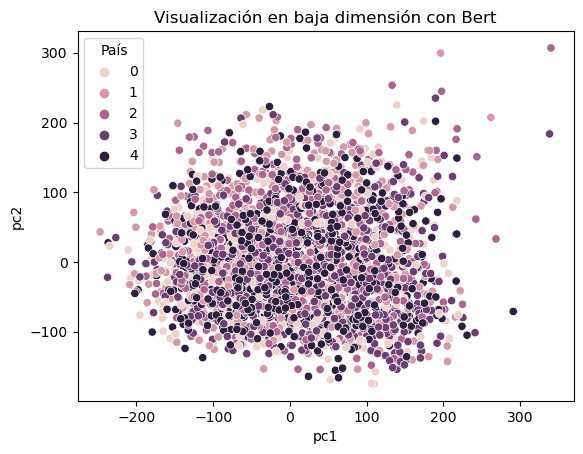

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.scatterplot(data=pca_feature,x='pc1', y='pc2', hue='País')
sns.set(style='whitegrid')
plt.title('Visualización en baja dimensión con Bert')
plt.show()

Recordemos que las etiquetas de cada país son las siguientes

In [17]:
tr_y_ind

{'ar': 0, 'cl': 1, 'es': 2, 'mx': 3, 'pe': 4}

#### Conclusiones

De la visualiación no se logra apreciar ningún patrón que permita diferenciar los blogs entre cada país. Uno de los factores que posiblemente halla unfluído para no encontrar patrones fue el alto costo computacional del modelo, para que puediera funcionar correctamente se necesitó que en el proceso tokenización se redujera a una longitud máxima de 32, ya que de lo contrario al sacar los últimos estados ocultos la memoria ram del equipo se agotaba. A continuación se muestra una visualización con la representación word2vec y tomando en cuenta el promedio de los embeddings.

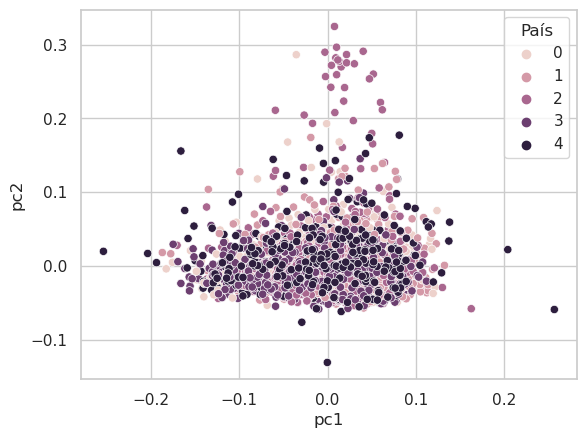

In [29]:
import IPython.display as ipd
ipd.Image("solucion2c.png",width=600)

Con respecto a los resultados obtenidos en el ejercicio 2 c) de la Tarea 2, no se logra notar una diferencia significativa al utilizar una representación con Bert(Beto) y una representación  basada en word2vec tomando el promedio de los embeddings. Solo se logra apreciar ligeramente que la representación de la tarea 2 es más compacta, a diferencia de la representación con Bert, ya que se logra apreciar ligeramente más distribuidos los datos.

### Solución de b)

In [19]:
tr_features = features[:len(tr_txt)]
te_features = features[len(tr_txt):]

#### Clasificador SVM

In [20]:
from sklearn import svm 
from sklearn import metrics
classifier = svm.SVC(kernel = "linear")
classifier.fit(tr_features,tr_y)
y_pred_svm = classifier.predict(te_features)
print(metrics.classification_report(te_y, y_pred_svm))

              precision    recall  f1-score   support

           0       0.29      0.40      0.34       200
           1       0.22      0.23      0.23       200
           2       0.46      0.41      0.43       200
           3       0.31      0.24      0.27       200
           4       0.32      0.28      0.30       200

    accuracy                           0.31      1000
   macro avg       0.32      0.31      0.31      1000
weighted avg       0.32      0.31      0.31      1000



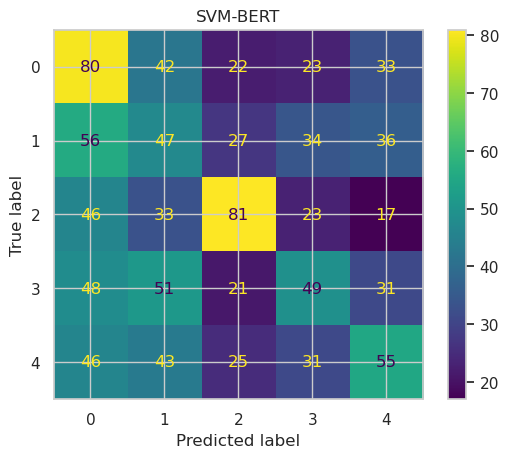

In [21]:
cm = metrics.confusion_matrix(te_y, y_pred_svm, labels=classifier.classes_, normalize =None)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.title('SVM-BERT')
plt.show()

#### Clasificador Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

modelo_rf = RandomForestClassifier(
            n_estimators = 100,
            max_depth    = None,
            max_features = 'auto',
            n_jobs       = -1,
         )
modelo_rf.fit(tr_features,tr_y)
y_pred_rf = modelo_rf.predict(te_features)
print(metrics.classification_report(te_y,y_pred_rf))

              precision    recall  f1-score   support

           0       0.28      0.21      0.24       200
           1       0.28      0.28      0.28       200
           2       0.44      0.48      0.46       200
           3       0.34      0.39      0.36       200
           4       0.30      0.31      0.31       200

    accuracy                           0.33      1000
   macro avg       0.33      0.33      0.33      1000
weighted avg       0.33      0.33      0.33      1000



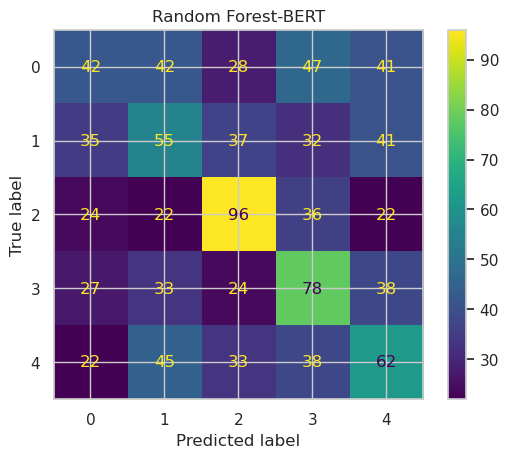

In [23]:
cm = metrics.confusion_matrix(te_y, y_pred_rf, labels=classifier.classes_, normalize =None)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()
plt.title('Random Forest-BERT')
plt.show()

**Resultados del ejercicio 2 d de la Tarea 2: Clasificadores SVM y Random Forest basados en word2vec**

              SVM con Word2vec
              
              precision    recall  f1-score   support

           0       0.33      0.06      0.09       200
           1       0.26      0.69      0.38       200
           2       1.00      0.04      0.07       200
           3       0.28      0.45      0.35       200
           4       0.28      0.14      0.18       200

    accuracy                           0.27      1000
   macro avg       0.43      0.27      0.21      1000
weighted avg       0.43      0.27      0.21      1000


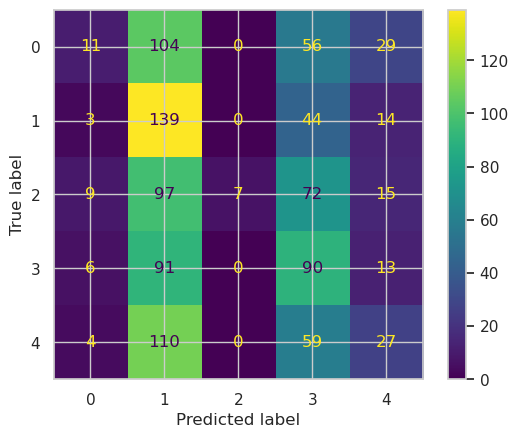

In [31]:
ipd.Image("solucion2dsvm.png",width=400)

              Random Forest con Word2vec
              
              precision    recall  f1-score   support

           0       0.37      0.25      0.30       200
           1       0.35      0.52      0.42       200
           2       0.54      0.60      0.57       200
           3       0.50      0.41      0.45       200
           4       0.37      0.34      0.36       200

    accuracy                           0.42      1000
   macro avg       0.43      0.42      0.42      1000
weighted avg       0.43      0.42      0.42      1000

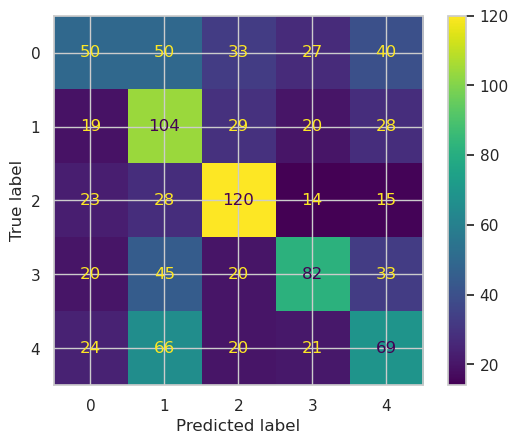

In [34]:
ipd.Image("solucion2drandomf.png",width=400)

**Conclusiones**

De los resultados obtenidos se logra apreciar que en cuanto al clasificador SVM, utilizar BERT da mejores resultados que utilizar una representación word2vec. Por el contrario, cuando se utiliza el clasificador Random Forest se obtienen mejores resultados con la representación word2vec que con BERT. El peor modelo es el clasificador SVM basado en word2vec y el mejor es cuando se utiliza Random Forest basado en word2vec.

Asimismo, una observación importante es que al utilizar BERT los resultados no varían tanto de un clasificador a otro. Cabe aclarar nuevamente que por el alto costo computacional, la longitud máxima de las secuencias se fijó en 32, a diferencia de los modelos de la tarea 2 donde el número máximo de palabras era de 75000, por lo tanto, este es un factor importante a tomar en cuenta para poder comparar ambos modelos. Aún así, BERT logra tener buenos resultados y hacer la clasificación de una manera balanceada.

3. Usando nuevamente el corpus `hispablogs.zip`, complementa los modelos de clasificación usando BERT con fine-tunning

    - a) congelando las capas de la arquitectura de BERT
    - b) haciendo el fine-tunning de la arquitectura completa (BERT+clasificador)
    
    Realiza un reporte breve sobre las ventajas/desventajas de cada enfoque, incluyendo las características de precisión, recursos de cómputo, etcétera. Especifica todos los parámetros que usaste, y discute brevemente el criterio que seguiste para usarlos.
    
    Puedes adaptar el notebook `BERT for sentiment analysis fine-tunning.ipynb` que está en el [github del curso](https://github.com/victorm0202/temas_selectos_CD), y que contempla ambas formas de fine-tunning.
    
    

In [7]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 2060 with Max-Q Design


In [8]:
print(device)

cuda


In [14]:
from sklearn.model_selection import train_test_split

X = data['blog'].values
y = data['label'].values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

In [13]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&' with '&'
    text = re.sub(r'&', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Separar las palabraas de hispablogs
    text.replace('\n', ' ').replace('_', ' ')

    return text

In [10]:
from transformers import BertTokenizer

# Load the BERT tokenizer
# BERT
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# Beto
tokenizer = BertTokenizer.from_pretrained("pytorch/", do_lower_case=False)


# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            truncation = True,
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks
     

In [11]:
# Encode our concatenated data
encoded_data = [tokenizer.encode(blog, add_special_tokens=True, truncation = True,            
            max_length=128) for blog in data['blog']]

# Find the maximum length
max_len = max([len(blog) for blog in encoded_data])
print('Max length: ', max_len)

Max length:  128


In [15]:
# Specify `MAX_LEN`
MAX_LEN = 128

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
#print('Original: ', X[0])
#print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Tokenizing data...


### Create PyTorch DataLoader

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 8

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

### Create BertClassifier

In [17]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=True):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 5

        # Instantiate BERT model
        #BERT---
        #self.bert = BertModel.from_pretrained('bert-base-uncased')
        #BETO---
        self.bert = BertForMaskedLM.from_pretrained("pytorch/")

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.LazyLinear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.LazyLinear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        #print(input_ids)
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 1.18 ms, sys: 5 µs, total: 1.18 ms
Wall time: 1 ms


### Optimizer & Learning Rate Scheduler

In [18]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=2, freeze_bert=True):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### Training Loop

In [19]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=2, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

### Evaluation on Validation Set

In [20]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

### Solución de a)

In [36]:
#set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2, freeze_bert = True)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at pytorch/ were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   6.211029   |     -      |     -     |   6.40   
   1    |   40    |   3.636628   |     -      |     -     |   6.87   
   1    |   60    |   2.884483   |     -      |     -     |   6.91   
   1    |   80    |   3.115326   |     -      |     -     |   7.38   
   1    |   100   |   2.478729   |     -      |     -     |   7.04   
   1    |   120   |   2.267872   |     -      |     -     |   7.12   
   1    |   140   |   3.015016   |     -      |     -     |   7.62   
   1    |   160   |   2.933013   |     -      |     -     |   7.90   
   1    |   180   |   2.932693   |     -      |     -     |   8.22   
   1    |   200   |   2.242045   |     -      |     -     |   8.48   
   1    |   220   |   2.028092   |     -      |     -     |   8.50   
   1    |   240   |   2.069032   |     -      |     -     |   8.40   


In [37]:
test

,blog,label
0,la dgcye informó que el de noviembre abonará l...,0
1,artículos relacionados airbag para peatones de...,0
2,el piloto de chevrolet agustín canapino consig...,0
3,hace tiempo que no propongo asociar imágenes c...,0
4,título cellular and molecular inmunology autor...,0
...,...,...
995,fotoselectas com te presenta una coleccion de ...,4
996,tengo bien indicar que el contenido de los vid...,4
997,aqui nuestra paloma fiuza bailando muy sexy en...,4
998,hay un lugar donde los guerreros son hijos del...,4


In [23]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')

X_test = test['blog'].values
y_test = test['label'].values
test_inputs, test_masks = preprocessing_for_bert(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=8)

Tokenizing data...


Resultados del modelo BERT frozen
              precision    recall  f1-score   support

           0       0.59      0.39      0.47       200
           1       0.58      0.49      0.53       200
           2       0.83      0.81      0.82       200
           3       0.63      0.41      0.50       200
           4       0.41      0.78      0.54       200

    accuracy                           0.57      1000
   macro avg       0.61      0.57      0.57      1000
weighted avg       0.61      0.57      0.57      1000



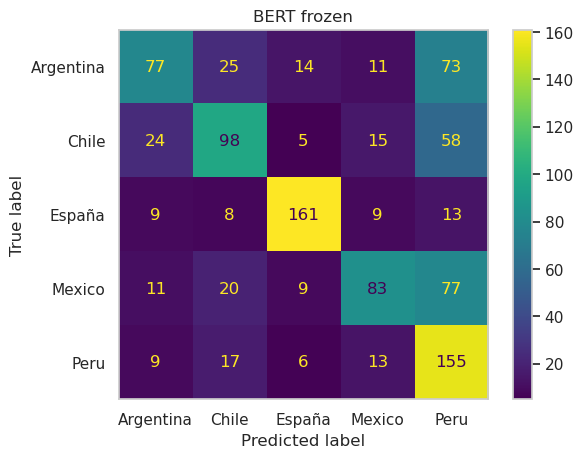

In [39]:
# Compute predicted probabilities on the test set
from sklearn import metrics
import matplotlib.pyplot as plt

probs = bert_predict(bert_classifier, test_dataloader)

# Evaluate the Bert classifier
#evaluate_roc(probs.argmax(axis=1), y_val)

print('Resultados del modelo BERT frozen')
print(metrics.classification_report(y_test, probs.argmax(axis=1)))
cm = metrics.confusion_matrix(y_test, probs.argmax(axis=1), labels=[0,1,2,3,4], normalize =None)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Argentina','Chile','España','Mexico','Peru'])
disp.plot()
plt.grid(False)
plt.title('BERT frozen')
plt.show()

### Solución de b)

In [21]:
#set_seed(42)    # Set seed for reproducibility
bert_classifier_ft, optimizer, scheduler = initialize_model(epochs=2, freeze_bert = False)
train(bert_classifier_ft, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at pytorch/ were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   2.811957   |     -      |     -     |   6.00   
   1    |   40    |   1.798091   |     -      |     -     |   5.10   
   1    |   60    |   1.963929   |     -      |     -     |   5.13   
   1    |   80    |   1.736856   |     -      |     -     |   5.15   
   1    |   100   |   1.611543   |     -      |     -     |   5.17   
   1    |   120   |   1.665219   |     -      |     -     |   5.20   
   1    |   140   |   1.482996   |     -      |     -     |   5.21   
   1    |   160   |   1.538953   |     -      |     -     |   5.24   
   1    |   180   |   1.347649   |     -      |     -     |   5.26   
   1    |   200   |   1.550066   |     -      |     -     |   5.27   
   1    |   220   |   1.501163   |     -      |     -     |   5.28   
   1    |   240   |   1.409876   |     -      |     -     |   5.31   


BERT fine-tuning
              precision    recall  f1-score   support

           0       0.71      0.74      0.73       200
           1       0.74      0.83      0.78       200
           2       0.94      0.89      0.91       200
           3       0.77      0.79      0.78       200
           4       0.84      0.73      0.78       200

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000



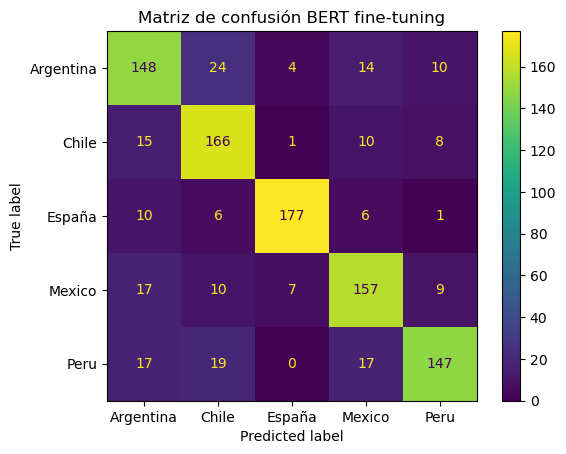

In [35]:
# Compute predicted probabilities on the test set
from sklearn import metrics
import matplotlib.pyplot as plt
# Compute predicted probabilities on the test set
probs_ft = bert_predict(bert_classifier_ft, test_dataloader)

# Evaluate the Bert classifier
#evaluate_roc(probs.argmax(axis=1), y_val)

print('BERT fine-tuning')
print(metrics.classification_report(y_test, probs_ft.argmax(axis=1)))
cm = metrics.confusion_matrix(y_test, probs_ft.argmax(axis=1),  labels=[0,1,2,3,4], normalize =None)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Argentina','Chile','España','Mexico','Peru'])
disp.plot()
plt.grid(False)
plt.title('Matriz de confusión BERT fine-tuning')
plt.show()

### Conclusiones

A continuación, se muestran los parámetros utilizados para cada modelo, se hace una comparación y se describe brevemente como se establecieron estos parámetros.

Parámetros del modelo con capas congeladas:
- batch_size = 8
- max-len = 256
- Learning rate (Adam) = 5e-5
- Number of epochs = 2

Parámetros del modelo con fine-tuning completo
- tamaño de batch = 8
- max-len = 128
- Learning rate (Adam) = 5e-5
- Number of epochs = 2

De los resultados obtenidos, se observa que ambos modelos logran un buen desempeño, sin embargo el modelo con fine-tuning completo es superior al modelo que utiliza capas congeladas, pero el costo computacional es bastante alto, específicamente en el consumo de la memoria de la tarjeta gráfica, debido a esto la longitud máxima de sencuencia se redujo a la mitad. Asimismo, por el costo computacional y para que los modelos pudieran correr el tamaño de batch se redujo a 8, en cuanto a los demás parámetros se mantuvieron iguales que los que vienen en **BERT for sentiment analysis fine-tunning.ipynb**. Con respecto a la clasificación se observa que BERT con fine-tuning completo logra una mejor clasificación en todos los países, y ambos modelos logran una precisión muy buena para detectar blogs de españa, y los blogs más difíciles de detectar son los de Argentina.

Como conclusión general y haciendo una comparación de todos los modelos para la clasificación de blogs del corpus hispablogs, cabe señalar que BERT con fine-tuning completo es el que arrojó los mejores resultados, o al menos con los parámetros utilizados en cada tarea, asimismo, se notó la felexibilidad de BERT a la hora de hacer la implementación a diferencia de otras arquitecturas. 